In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
!cp /content/drive/MyDrive/datasets/archive.zip /content/ #https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

In [ ]:
!unzip archive.zip

In [ ]:
train_data_dir = "/content/Face Mask Dataset/Train"
val_data_dir = '/content/Face Mask Dataset/Validation'
batch_size = 32
size = 224

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.1
    )
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size=batch_size,
    shuffle = True,
    target_size=(size, size),
    class_mode='binary')
validation_generator = train_datagen.flow_from_directory(
    val_data_dir,# same directory as training data
    batch_size=batch_size,
    shuffle = True,
    target_size=(size, size),
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
total_train = 10000
total_val = 800

In [ ]:
sample_training_images, _ = next(validation_generator)

In [ ]:
# plot 5 images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


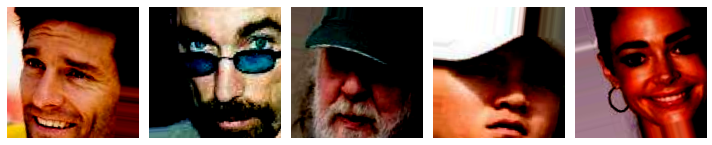

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
sample_training_images.shape

(32, 224, 224, 3)

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False) # Download pre-trained mobilenetv2

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(640,kernel_regularizer=keras.regularizers.l2(0.001), activation = 'relu'), ##
  tf.keras.layers.Dropout(.4),
  tf.keras.layers.Dense(120,kernel_regularizer=keras.regularizers.l2(0.001), activation = 'relu'), ##
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [ ]:
len(model.trainable_variables)

162

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               76920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
logit_batch = model(sample_training_images).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.29705572
max logit: 0.7921156

Shape: (32, 1)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
epochs = 6

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size,
    verbose=2
)

Epoch 1/6
312/312 - 152s - loss: 0.7545 - binary_accuracy: 0.9843 - val_loss: 4.2348 - val_binary_accuracy: 0.8413
Epoch 2/6
312/312 - 150s - loss: 0.2758 - binary_accuracy: 0.9944 - val_loss: 1.1659 - val_binary_accuracy: 0.9413
Epoch 3/6
312/312 - 148s - loss: 0.1229 - binary_accuracy: 0.9926 - val_loss: 0.3026 - val_binary_accuracy: 0.9800
Epoch 4/6
312/312 - 148s - loss: 0.0536 - binary_accuracy: 0.9959 - val_loss: 0.0623 - val_binary_accuracy: 0.9962
Epoch 5/6
312/312 - 149s - loss: 0.0303 - binary_accuracy: 0.9967 - val_loss: 0.0430 - val_binary_accuracy: 0.9975
Epoch 6/6
312/312 - 148s - loss: 0.0204 - binary_accuracy: 0.9968 - val_loss: 0.0324 - val_binary_accuracy: 0.9987


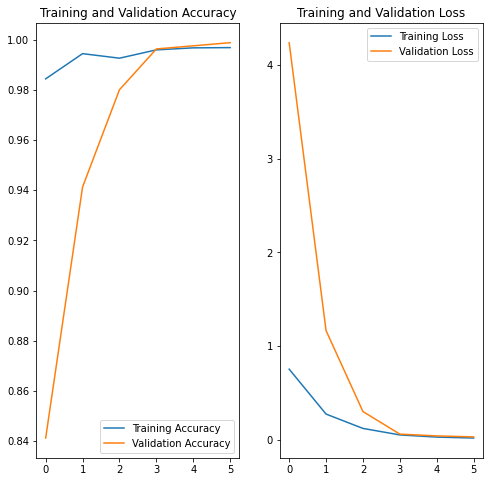

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for layer in model.layers[:1]: # Freeze mobileNet
  layer.trainable =  False

In [ ]:
len(model.trainable_variables)

6

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               819840    
_________________________________________________________________
dropout (Dropout)            (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               76920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
new_epochs = 5

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=new_epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/5
312/312 [==============================] - 122s 390ms/step - loss: 0.0107 - binary_accuracy: 0.9985 - val_loss: 0.0076 - val_binary_accuracy: 1.0000
Epoch 2/5
312/312 [==============================] - 120s 385ms/step - loss: 0.0109 - binary_accuracy: 0.9982 - val_loss: 0.0120 - val_binary_accuracy: 0.9987
Epoch 3/5
312/312 [==============================] - 120s 386ms/step - loss: 0.0096 - binary_accuracy: 0.9985 - val_loss: 0.0073 - val_binary_accuracy: 1.0000
Epoch 4/5
312/312 [==============================] - 120s 383ms/step - loss: 0.0085 - binary_accuracy: 0.9992 - val_loss: 0.0046 - val_binary_accuracy: 1.0000
Epoch 5/5
312/312 [==============================] - 119s 382ms/step - loss: 0.0086 - binary_accuracy: 0.9989 - val_loss: 0.0044 - val_binary_accuracy: 1.0000


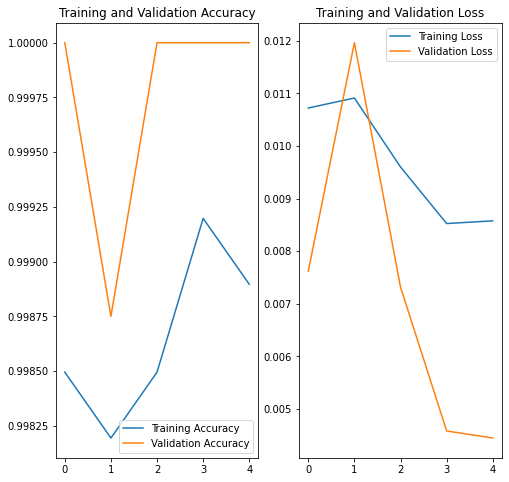

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(new_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_data_dir = '/content/Face Mask Dataset/Test'

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,# same directory as training data
    batch_size=batch_size,
    target_size=(size, size),
    class_mode='binary')

Found 992 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(test_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


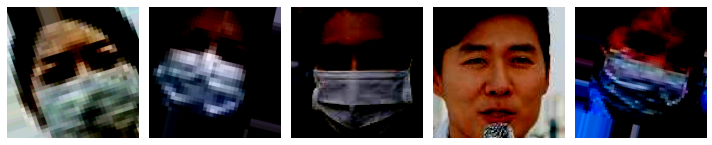

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
results = model.evaluate(test_generator)

31/31 [==============================] - 2s 72ms/step - loss: 0.0110 - binary_accuracy: 0.9980


In [ ]:
print('test loss, test acc:', results)

test loss, test acc: [0.010966171510517597, 0.9979838728904724]


In [ ]:
cd /content/Face Mask Dataset

/content/Face Mask Dataset


In [ ]:
!mkdir Test1

In [ ]:
cd Test1

/content/Face Mask Dataset/Test1


In [ ]:
!cp /content/drive/MyDrive/datasets/Testmask.zip /content #own Dataset Test 30 withMask 152 withoutMask

In [ ]:
!unzip /content/Testmask.zip

In [ ]:
test2_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test2_data_dir = '/content/Face Mask Dataset/Test1'

In [ ]:
test2_generator = test2_datagen.flow_from_directory(
    test2_data_dir,
    batch_size=batch_size,
    target_size=(size, size),
    class_mode='binary')

Found 182 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


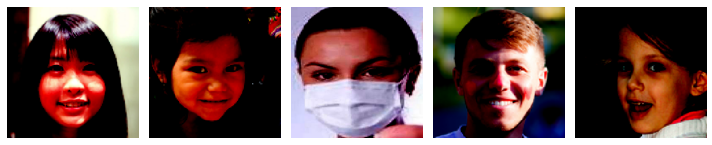

[1. 1. 0. 1. 1.]


In [ ]:
sample_training_images1, i = next(test2_generator)
plotImages(sample_training_images1[:5])
print(i[:5])

In [ ]:
results = model.evaluate(test2_generator)

6/6 [==============================] - 1s 95ms/step - loss: 0.1838 - binary_accuracy: 0.9670


In [ ]:
print('test loss, test acc:', results)

test loss, test acc: [0.183795765042305, 0.9670329689979553]


In [ ]:
model.save('maskmobv2.h5')